# Dependencies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from xgboost import XGBClassifier

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, Dropout, MaxPool1D, LSTM
from tensorflow.keras.optimizers import Adam

from events_to_pd import events_to_pd
from gen_feats import gen_feats

# Load data

In [24]:
%%time
bkg_path = "bb1/run_a0.txt"
sig_path = "dark1/run_a0.txt"
bkg_path_test = "bb2/run_a0.txt"
sig_path_test = "dark2/run_a0.txt"

max_ev = int(1e5)

bkg, bkg_j = events_to_pd(bkg_path,max_ev)
sig, sig_j = events_to_pd(sig_path,max_ev)
bkg_test, bkg_j_test = events_to_pd(bkg_path_test,max_ev)
sig_test, sig_j_test = events_to_pd(sig_path_test,max_ev)

print("num Background train jets = {}".format(len(bkg_j)))
print("num Signal train jets = {}".format(len(sig_j)))
print("num Background test jets = {}".format(len(bkg_j_test)))
print("num Signal test jets = {}".format(len(sig_j_test)))

num Background train jets = 30215
num Signal train jets = 23727
num Background test jets = 29767
num Signal test jets = 23671
Wall time: 3min 29s


In [26]:
bkg.to_pickle("data/bkg")
bkg_j.to_pickle("data/bkg_j")
sig.to_pickle("data/sig")
sig_j.to_pickle("data/sig_j")
bkg_test.to_pickle("data/bkg_test")
bkg_j_test.to_pickle("data/bkg_j_test")
sig_test.to_pickle("data/sig_test")
sig_j_test.to_pickle("data/sig_j")

In [7]:
%%time
bkg = pd.read_pickle("data/bkg")
bkg_j = pd.read_pickle("data/bkg_j")
sig = pd.read_pickle("data/sig")
sig_j = pd.read_pickle("data/sig_j")
bkg_test = pd.read_pickle("data/bkg_test")
bkg_j_test = pd.read_pickle("data/bkg_j_test")
sig_test = pd.read_pickle("data/sig_test")
sig_j_test = pd.read_pickle("data/sig_j")

Wall time: 7.17 s


# Create features

In [8]:
%%time
n_constits = 25

bkg, bkg_j = gen_feats(bkg, bkg_j, n_constits=n_constits, label=0, boost_and_shift=True, sort="absD0")
sig, sig_j = gen_feats(sig, sig_j, n_constits=n_constits, label=1, boost_and_shift=True, sort="absD0")

bkg_test, bkg_j_test = gen_feats(bkg_test, bkg_j_test, n_constits=n_constits, label=0, boost_and_shift=True, sort="absD0")
sig_test, sig_j_test = gen_feats(sig_test, sig_j_test, n_constits=n_constits, label=1, boost_and_shift=True, sort="absD0")

Wall time: 3min


In [7]:
bkg_j.head()

,Event,Jet,PT,Eta,Phi,mult_track,mult_tower,sumPx,sumPy,PT_track,...,DeltaR_track,D0_track,DZ_track,PT_tower,Eta_tower,Phi_tower,DeltaR_tower,MET,maxD0,label
0,1,1,154.765,-0.949109,-2.727570,9,15,-138.119331,-60.693523,"[57.2726, 12.9823, 9.08256, 5.47551, 4.66965, ...",...,"[0.0678794, 0.0610078, 0.0680169, 0.0543531, 0...","[0.0926393, 0.00104306, 0.00190373, -0.0426708...","[-0.18709, 0.200578, -0.136752, -0.129054, -0....","[92.7263, 10.3008, 8.77416, 7.62353, 5.96511, ...","[-0.948645, -0.966066, -0.892382, -0.935221, -...","[-2.73277, -2.75509, -2.78226, -2.69846, -2.67...","[0.00522717, 0.0323247, 0.0787963, 0.0322513, ...",150.866342,0.092639,0
1,1,2,117.169,-1.728220,0.614835,8,13,92.876916,65.584130,"[31.0997, 23.8363, 7.36628, 5.6948, 3.8901, 3....",...,"[0.0417874, 0.0702219, 0.0637029, 0.117505, 0....","[0.0345435, 0.0702087, -0.0861242, -0.0495073,...","[-0.114731, -0.508576, -0.539706, 0.0398727, 0...","[65.9337, 14.1232, 12.1697, 11.946, 3.96994, 1...","[-1.69938, -1.73149, -1.74456, -1.73312, -1.67...","[0.592044, 0.604753, 0.798072, 0.557527, 0.647...","[0.036757, 0.0105981, 0.183964, 0.0575174, 0.0...",113.698723,0.034543,0
2,2,1,192.534,0.881347,-2.883480,11,25,-182.341271,-48.137319,"[31.9853, 15.173, 12.7997, 12.1929, 11.9221, 1...",...,"[0.0506226, 0.0148335, 0.0638486, 0.0553604, 0...","[-0.101334, 0.0758976, -0.0906685, 1.2702, -0....","[0.833184, -0.420616, 0.447464, -1.25446, 0.02...","[78.1232, 31.9573, 17.7868, 16.2995, 6.45135, ...","[0.823999, 0.958713, 0.845423, 0.813869, 0.901...","[-2.87367, -2.86085, -2.84399, -2.71754, -2.79...","[0.0581816, 0.0806095, 0.0533902, 0.179135, 0....",188.588283,-0.101334,0
3,2,2,174.052,0.751863,0.214220,12,19,166.152380,36.147836,"[22.6572, 19.2685, 18.5948, 16.2527, 8.93074, ...",...,"[0.0465386, 0.0325494, 0.046352, 0.0651489, 0....","[-0.0134758, -0.0203993, 0.145087, -0.00320931...","[0.058743, -0.0605345, -0.019895, -0.0110237, ...","[79.731, 29.4728, 16.4945, 10.0371, 8.79076, 5...","[0.792556, 0.710023, 0.730408, 0.649827, 0.744...","[0.269854, 0.192804, 0.000681421, 0.120946, 0....","[0.068928, 0.0470026, 0.214614, 0.138244, 0.01...",170.039052,-0.013476,0
4,3,1,162.934,-1.164060,-2.494510,10,15,-126.977381,-95.945945,"[30.0525, 7.27038, 4.28302, 3.95571, 3.3523, 2...",...,"[0.0317486, 0.0264253, 0.0725693, 0.118105, 0....","[0.106265, -0.0453424, 0.00193799, -0.0399016,...","[-0.2378, -0.234499, -0.0835195, -0.00895009, ...","[55.6416, 28.0006, 17.5064, 14.307, 13.5087, 6...","[-1.10117, -1.19329, -1.18089, -1.2124, -1.200...","[-2.482, -2.54561, -2.51794, -2.46633, -2.5089...","[0.0641177, 0.0588712, 0.0288496, 0.055952, 0....",159.150493,0.106265,0


# LSTM classifier

## Train/Validation split

In [29]:
sig_j.shape

(22145, 27)

In [41]:
%%time
feats = ["PT_track", "DeltaR_track", "D0_track", "DZ_track"]

val_frac = 0.3

data = pd.concat([sig_j,bkg_j.loc[range(sig_j.shape[0])]]).sample(frac=1).reset_index()

train_ind = np.arange(0,int(len(data)*(1-val_frac))) 
val_ind = np.arange(int(len(data)*(1-val_frac)),len(data))


X_train = np.concatenate(np.array(data.copy().iloc[train_ind][feats].applymap(np.array)).flatten()).reshape(len(train_ind), n_constits, len(feats))
y_train = data.iloc[train_ind]["label"]

X_val =np.concatenate(np.array(data.copy().iloc[val_ind][feats].applymap(np.array)).flatten()).reshape(len(val_ind), n_constits, len(feats))
y_val = data.loc[val_ind]["label"]

X_test_B = np.concatenate(np.array(bkg_j_test.copy()[feats].applymap(np.array)).flatten()).reshape(len(bkg_j_test), n_constits, len(feats))
X_test_S = np.concatenate(np.array(sig_j_test.copy()[feats].applymap(np.array)).flatten()).reshape(len(sig_j_test), n_constits, len(feats))

print("num total examples = {}".format(len(data)))
print("num train examples = {}".format(len(train_ind)))
print("num validate examples = {}".format(len(val_ind)))

num total examples = 44290
num train examples = 31002
num validate examples = 13288
Wall time: 1.44 s


## Model

In [42]:
#Define model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_constits, len(feats)), return_sequences=False))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

#Compile
sgd = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=sgd,loss='binary_crossentropy')
model.summary()

# Callbacks
checkpoint = tf.keras.callbacks.ModelCheckpoint('lstm_WandB', verbose=1, monitor='val_loss', save_best_only=True, mode='auto')
es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0.001, patience=5, verbose=1, mode="auto", baseline=None, restore_best_weights=False)

#Train model
train_history = model.fit(X_train, y_train, batch_size=1000, epochs=30, validation_data=(X_val,y_val), callbacks=[checkpoint, es])

#Load best weights
model = tf.keras.models.load_model("lstm_WandB")

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 50)                11000     
_________________________________________________________________
dense_8 (Dense)              (None, 16)                816       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 17        
Total params: 11,833
Trainable params: 11,833
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
31/32 [============================>.] - ETA: 0s - loss: 0.6672
Epoch 00001: val_loss improved from inf to 0.65265, saving model to lstm_WandB
INFO:tensorflow:Assets written to: lstm_WandB\assets
32/32 [==============================] - 12s 386ms/step - loss: 0.6672 - val_loss: 0.6526
Epoch 2/30
31/32 [============================>.] - ETA: 0s - loss: 0.6381
Epoch 00

In [39]:
#Train model
train_history = model.fit(X_train, y_train, batch_size=1000, epochs=50, validation_data=(X_val,y_val), callbacks=[checkpoint, es])


Epoch 1/50
31/32 [============================>.] - ETA: 0s - loss: 0.3650
Epoch 00001: val_loss did not improve from 0.38876
32/32 [==============================] - 10s 306ms/step - loss: 0.3650 - val_loss: 0.4211
Epoch 2/50
31/32 [============================>.] - ETA: 0s - loss: 0.3791
Epoch 00002: val_loss did not improve from 0.38876
32/32 [==============================] - 10s 300ms/step - loss: 0.3791 - val_loss: 0.3912
Epoch 3/50
31/32 [============================>.] - ETA: 0s - loss: 0.3683
Epoch 00003: val_loss improved from 0.38876 to 0.37384, saving model to lstm_WandB
INFO:tensorflow:Assets written to: lstm_WandB\assets
32/32 [==============================] - 11s 339ms/step - loss: 0.3683 - val_loss: 0.3738
Epoch 4/50
31/32 [============================>.] - ETA: 0s - loss: 0.3419
Epoch 00004: val_loss did not improve from 0.37384
32/32 [==============================] - 10s 300ms/step - loss: 0.3419 - val_loss: 0.3962
Epoch 5/50
31/32 [============================>.] -

## Evaluate

sig_eff=0.44734225275718675
bkg_eff=0.013216166265648428
Wall time: 13 s


(array([  859.,   601.,   519.,   486.,   763.,   880.,  1003.,  1298.,
         2799., 12916.]),
 array([5.3676963e-04, 1.0048309e-01, 2.0042941e-01, 3.0037573e-01,
        4.0032205e-01, 5.0026840e-01, 6.0021472e-01, 7.0016104e-01,
        8.0010736e-01, 9.0005368e-01, 1.0000000e+00], dtype=float32),
 <BarContainer object of 10 artists>)

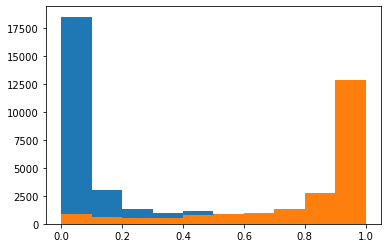

In [45]:
%%time
model = tf.keras.models.load_model("lstm_WandB")
thresh = 0.95

bkg_preds = model.predict(X_test_B).flatten()
sig_preds = model.predict(X_test_S).flatten()
bkg_eff = sum(bkg_preds>thresh)/len(bkg_preds)
sig_eff = sum(sig_preds>thresh)/len(sig_preds)

print("sig_eff={}".format(sig_eff))
print("bkg_eff={}".format(bkg_eff))

plt.hist(bkg_preds, bins=10);
plt.hist(sig_preds, bins=10);


Wall time: 7.2 s


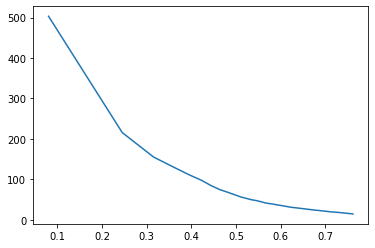

In [27]:
%%time
sig_eff = []
bkg_eff = []
frac = []
for thresh in (1-np.arange(0.001,0.5,0.01)):
    bkg_eff_temp = sum(bkg_preds>thresh)/len(bkg_preds)
    sig_eff_temp = sum(sig_preds>thresh)/len(sig_preds)
    sig_eff.append(sig_eff_temp)
    bkg_eff.append(1/bkg_eff_temp)
plt.plot(sig_eff,bkg_eff)    